# CSCI4022 Homework 7; Undirected Graphs


## Due Monday, November 8 at 11:59 pm to Canvas and Gradescope

#### Submit this file as a .ipynb with *all cells compiled and run* to the associated dropbox.

***

Your solutions to computational questions should include any specified Python code and results as well as written commentary on your conclusions.  Remember that you are encouraged to discuss the problems with your classmates, but **you must write all code and solutions on your own**.

**NOTES**: 

- Any relevant data sets should be available on Canvas. To make life easier on the graders if they need to run your code, do not change the relative path names here. Instead, move the files around on your computer.
- If you're not familiar with typesetting math directly into Markdown then by all means, do your work on paper first and then typeset it later.  Here is a [reference guide](https://math.meta.stackexchange.com/questions/5020/mathjax-basic-tutorial-and-quick-reference) linked on Canvas on writing math in Markdown. **All** of your written commentary, justifications and mathematical work should be in Markdown.  I also recommend the [wikibook](https://en.wikibooks.org/wiki/LaTeX) for LaTex.
- Because you can technically evaluate notebook cells is a non-linear order, it's a good idea to do **Kernel $\rightarrow$ Restart & Run All** as a check before submitting your solutions.  That way if we need to run your code you will know that it will work as expected. 
- It is **bad form** to make your reader interpret numerical output from your code.  If a question asks you to compute some value from the data you should show your code output **AND** write a summary of the results in Markdown directly below your code. 
- 45 points of this assignment are in problems.  The remaining 5 are for neatness, style, and overall exposition of both code and text.
- This probably goes without saying, but... For any question that asks you to calculate something, you **must show all work and justify your answers to receive credit**. Sparse or nonexistent work will receive sparse or nonexistent credit. 
- There is *not a prescribed API* for these problems.  You may answer coding questions with whatever syntax or object typing you deem fit.  Your evaluation will primarily live in the clarity of how well you present your final results, so don't skip over any interpretations!  Your code should still be commented and readable to ensure you followed the given course algorithm.

---
**Shortcuts:**  [Problem 1](#p1) | [Problem 2](#p2) | [Problem 3](#p3) | [Problem 4](#p4) | [Extra Credit](#ec) |
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
# import scipy.stats as stats
# import statsmodels.api as sm

In [2]:
PLOT_SIZE_X = 10
PLOT_SIZE_Y = 6
FONT_SIZE   = 16

***
<a/ id='p1'></a>
[Back to top](#top)
# Problem 1 (Theory: Network MLEs; 5 pts)

Suppose graphs are generated by picking a probability $p$ and choosing each edge independently with probability $p$, as if our entire network were coming from a Community Affiliation Graph Model (AGM) with only *one*  universal community.

- What value of $\hat{p}$ gives the maximum likelihood of seeing a specific graph with $n$ total nodes and $e$ total edges?
- What is the probability that your observed graph is the one generated if in fact $p=\hat{p}$?

*Hint/Intuition*: if you have 4 nodes and observe 3 total edges, what should P(edge) be?  What would be the resulting P(graph)?

**Solution**: 


***
<a/ id='p2'></a>
[Back to top](#top)
# Problem 2 (Initializing BigCLAM: PageRank; 10 pts)

Below is some code to load in and plot a modified variation of the "Tutte" graph, an otherwise 3-way symmetric graph.  Note that you are given both

- `edges`, a list of the edges of the graph
- `neighbors`, a dictionary holding the lists of the neighboring vertices for any provided integer vertex-key

which can be used for desired algorithms.

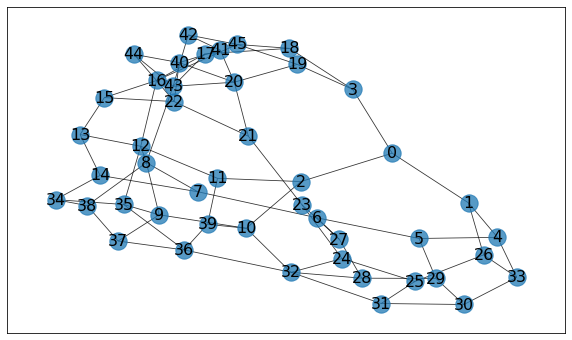

In [3]:
#NB: this is a well known graph known as the "Tutte" graph
edges=[(0, 1), (0, 2), (0, 3), (1, 4), (1, 26), (2, 10), (2, 11), (3, 18), (3, 19), \
       (4, 5), (4, 33), (5, 6), (5, 29), (6, 7), (6, 27), (7, 8), (7, 14), (8, 9), (8, 38), \
       (9, 10), (9, 37), (10, 39), (11, 12), (11, 39), (12, 13), (12, 35), (13, 14), (13, 15),\
       (14, 34), (15, 16), (15, 22), (16, 17), (16, 44), (17, 18), (17, 43), (18, 45), (19, 20), \
       (19, 45), (20, 21), (20, 41), (21, 22), (21, 23), (22, 40), (23, 24), (23, 27), (24, 25), \
       (24, 32), (25, 26), (25, 31), (26, 33), (27, 28), (28, 29), (28, 32), (29, 30), (30, 31), \
       (30, 33), (31, 32), (34, 35), (34, 38), (35, 36), (36, 37), (36, 39), (37, 38), (40, 41), \
       (40, 44), (41, 42), (42, 43), (42, 45), (43, 44)]
#add a few edges for fun and value and to break symmetry
newedges=[(32,36), (32,10), (20,40), (20,43), (8,12), (8,43), (12,16), (35,9), (16,45), (16,22)]
for newedge in newedges:
    edges.append(newedge)

nodes=list(range(46))
neighbors={key: [] for key in range(len(nodes))} 
for edge in edges:
    neighbors[edge[0]].append(edge[1])
    neighbors[edge[1]].append(edge[0])

G=nx.Graph()
G.add_nodes_from(nodes)
for i in range(len(edges)):
    G.add_edge(edges[i][0],edges[i][1])

np.random.seed(4022)
pos = nx.spring_layout(G) #algorithm that tries to "cluster" node plot locations; it saves the xy coords of each vertex
labels=dict(zip(range(46),range(46))); #label 0-45

fig, ax = plt.subplots(figsize=(PLOT_SIZE_X, PLOT_SIZE_Y))

nx.draw_networkx_nodes(G, pos, node_size=300, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.8); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=FONT_SIZE); #label vertices by index/number

Our goal is to come up with a sensibile initialization before we run BigCLAM.  The [original paper](https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf) for BigCLAM suggests using "locally minimal neighborhoods."  Rather than figure out a new algorithm, let's try initialzing by:

1) Run PageRank on the Graph, treating each edge $(a,b)$ as *both* the directed edges $a \to b$ and $b \to a$.

2) Extract the node with the highest PageRank as an initial "center" to get community affiliation of "1" for community $A$.

3) For community B's intial center, get the node with the highest PageRank that's not connected to the node in 2).

4) For community C's intial center, get the node with the highest PageRank that's not connected to either of the nodes in 2) and 3).

Plot your resulting initialization, as in the example code below.

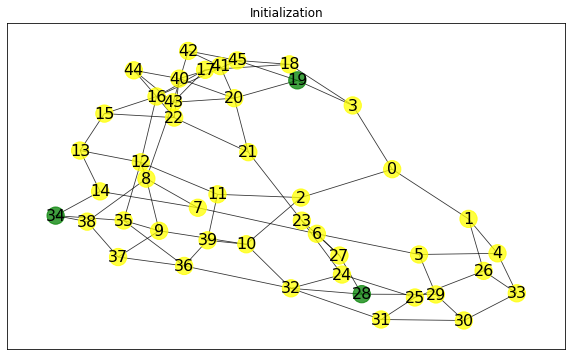

In [4]:
#Here's some colors on this
#random example initialization
centers=set([19,28,34])
colorf=lambda x: 'green' if (x in centers) else 'yellow'
colors=[colorf(node) for node in nodes]

fig, ax = plt.subplots(figsize=(PLOT_SIZE_X,PLOT_SIZE_Y))

#draw the nodes, using xy-node layout 'pos' provided
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.8); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=FONT_SIZE); #label vertices by index/number
ax.set_title('Initialization');

In [ ]:
#Your pagerank and plot here

In [5]:
####################################################################

def UndirectedColumnStochastic(edges, N):
    mat = np.zeros((N, N))
    for edge in edges:
        i = edge[0]
        j = edge[1]
        mat[i,j] = 1
        mat[j,i] = 1
    for col in range(N):
        s = np.sum(mat[:,col])
        if s != 0:
            mat[:,col] /= s
    return mat

####################################################################

def get_neighbors(nodes, edges):
    neighbors= {node: [] for node in nodes} 
    for edge in edges:
        neighbors[edge[0]].append(edge[1])
        neighbors[edge[1]].append(edge[0])
    return neighbors

####################################################################

def dist_L2(x,y):
    return np.sqrt(np.sum((x-y)**2))

def rank_links(links, ranks):
    l = list()
    for i, link in enumerate(links):
        l.append((link, ranks[i]))
    return sorted(l, key=lambda x: x[1], reverse=True)

####################################################################

def sparse_pagerank(Compact_Matrix):
    BETA       = 0.8
    all_links  = get_all_links(Compact_Matrix)
    n          = len(all_links)
    r_old      = np.repeat(1/n, n)
    tolerance  = 10e-6
    converged  = False
    iterations = 0
    while not converged:
        r_new = np.repeat((1-BETA)/n, n)
        # distribute importance payments between the nodes
        for link, outlinks in Compact_Matrix.items():
            d_i = len(outlinks)
            for outlink in outlinks:
                j         = all_links.index(outlink)
                i         = all_links.index(link)
                r_new[j] += ((BETA * r_old[i]) / d_i)
        r_new /= np.sum(r_new)
        if dist_L2(r_new, r_old) <= tolerance:
            converged = True
        r_old  = r_new.copy()
        iterations += 1
    r = rank_links(all_links, r_new)
    return r, iterations

def get_all_links(Compact_Matrix):
    s = set(Compact_Matrix.keys())
    for value in Compact_Matrix.values():
        for item in value:
            s.add(item)
    return list(s)

####################################################################

def PageRank(M, indices_to_names):
    n     = M.shape[0]
    BETA  = 0.8
    Nmat  = np.ones((n,n))/n
    A1    = BETA*M + (1-BETA)*Nmat
    r_old = np.repeat(1/n, n)
    r_new = np.ones(n)
    tolerance = 10e-6
    iters     = 0
    converged = False
    while not converged:
        r_new = np.matmul(A1, r_old)
        if dist_L2(r_new, r_old) <= tolerance: 
            converged = True
        r_old = r_new.copy()
        iters += 1
    r = rank_links(indices_to_names, r_new)   
    return r, iters

####################################################################

def initialize_communities(r, neighbors, n):
    l = []
    if n == 0:
        return l
    else:
        l.append(r[0][0])
        for _ in range(n-1):
            all_neighbors = [item for i in l for item in neighbors[i]]
            max_val = 0
            for node in r:
                if node[0] not in all_neighbors and node[0] not in l and node[1] > max_val:
                    max_val = node[1]
                    l.append(node[0])
        return l
                
####################################################################

In [6]:
##################################
n     = len(nodes)
##################################
mat   = UndirectedColumnStochastic(edges, n)
##################################
total = mat.size
zeros = total - np.count_nonzero(mat)
print(f'The matrix is {n} X {n}\nThere are {zeros} zeros out of {total} total entries: {np.round((zeros/total) * 100, 2)}%')
##################################
num_to_display = 20
##################################
sparse_r, sparse_iters = sparse_pagerank(neighbors)
print(f'Top {num_to_display} node ranks:\n{sparse_r[:num_to_display]}')
print(f'Number of iterations: {sparse_iters}')
##################################
r, iters = PageRank(mat, nodes)
print(f'Top {num_to_display} node ranks:\n{r[:num_to_display]}')
print(f'Number of iterations: {iters}')
##################################

The matrix is 46 X 46
There are 1958 zeros out of 2116 total entries: 92.53%
Top 20 node ranks:
[(16, 0.03297767710889954), (32, 0.030253473356183013), (20, 0.02862912315461888), (8, 0.02845200889064079), (12, 0.02825149775459592), (43, 0.028126760798845896), (10, 0.02430181518015813), (36, 0.024076127556250423), (45, 0.023971411058442832), (35, 0.02358603663265301), (9, 0.02353851311589241), (22, 0.02342870936847766), (40, 0.023337409433088766), (4, 0.021348369572199023), (33, 0.021329164328575814), (26, 0.021247073667926088), (1, 0.021220371606918132), (5, 0.021200492745102693), (30, 0.02107862126585504), (29, 0.021044721497828923)]
Number of iterations: 17
Top 20 node ranks:
[(16, 0.032977677108899525), (32, 0.03025347335618299), (20, 0.028629123154618866), (8, 0.02845200889064078), (12, 0.028251497754595914), (43, 0.028126760798845886), (10, 0.024301815180158125), (36, 0.024076127556250413), (45, 0.023971411058442825), (35, 0.023586036632653004), (9, 0.0235385131158924), (22, 0.023

In [7]:
communities = initialize_communities(r, neighbors, 3)
A = communities[0]
print(f"Neighbors of {A}: {neighbors[A]}")
B = communities[1]
print(f"Neighbors of {B}: {neighbors[B]}")
C = communities[2]
print(f"Neighbors of {C}: {neighbors[C]}")

print(f"Centers are: {A}, {B}, {C}")

Neighbors of 16: [15, 17, 44, 12, 45, 22]
Neighbors of 32: [24, 28, 31, 36, 10]
Neighbors of 20: [19, 21, 41, 40, 43]
Centers are: 16, 32, 20


---

I don't love these centers... But I don't doubt my pagerank solution, so I'm not sure!

---

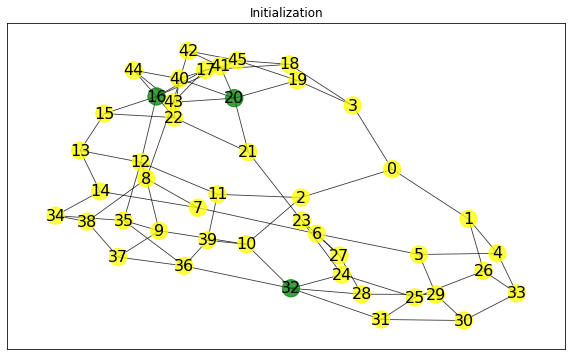

In [8]:
centers=set([A, B, C])
colorf=lambda x: 'green' if (x in centers) else 'yellow'
colors=[colorf(node) for node in nodes]

fig, ax = plt.subplots(figsize=(PLOT_SIZE_X,PLOT_SIZE_Y))

#draw the nodes, using xy-node layout 'pos' provided
nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.8); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=FONT_SIZE); #label vertices by index/number
ax.set_title('Initialization');

---



---

***
<a/ id='p3'></a>
[Back to top](#top)
# Problem 3 (Running BigCLAM: 15 pts)

Run BigCLAM on the Tutte graph from Problem 2.

- [ ] Use 3 communities *AND* a background community such that the probability of any 2 members sharing an edge from the background community is 1%.
- [ ] Initialize your communities with your solution to Problem 2.  If you are unable/did not yet to solve problem 2, you may use the (incorrect) values in the provided code of `[19,28,34]`.
- [x] You may iterate over the nodes in the order of their index instead of shuffling them.
- [x] Run until convergence by the $L_2$ norm  (element-wise over F) to within $10^{-6}$.
- [ ] At the end, create 3 side-by-side plots of the original graph colored by the 3 community affiliation columns.

In [ ]:
#Do the thing

In [ ]:
'''
My attempt at overhauling the notebook code
'''


def initialize_F(centers, neighbors, num_nodes):
    num_communities = len(centers)
    F = np.zeros((num_nodes, num_communities + 1))
    for j, i in enumerate(centers):
        F[i, j] = 1
    F[:,-1] = 0.01
    return F

F = initialize_F(centers, neighbors, len(nodes))
print(F)

c = 3
comm_sums=F.sum(0) #sum over all communities, cached for updating in later version
nu=.1 #step size
for lezgo in range(100): #number of iterations
    for i in nodes: #loop over rows of F
        F_grad=np.zeros(c) #initialize gradient
        comm_sums=F.sum(0) #should be cached, will deal with later since it's annoying to update correctly with the 0-check
        for j in neighbors[i]: #loop over nbrs of that row's node
                IP=np.exp(-np.inner(F[i], F[j])) #so we don't have to double compute
                print("IP: ", IP)
                F_grad+=F[j][:c]*(IP/(1-IP)+1) ##"first sum" below.
                print("F_grad: ", F_grad)
        step=nu*(F_grad-comm_sums[:c]-F[i][:c]) #
        print(step)
        F[i][:c]+=step #update row; doing as two steps so can use "step" to update comm_sums later
        F[i,F[i,:]<0]=0 #0-check
        #print('i',i,'step:', F_grad, 'baseline:',comm_sums) # sanity checks
print(F)

In [ ]:
'''
My own attempt
'''

class bigCLAM:
    def __init__(self, edges, k, centers, background_prob=None, step_size=0.1):
        # edge list
        self.edges     = edges
        # node list
        self.nodes     = list(set([node for edge in edges for node in edge]))
        # dictionary that contains the neighbors of node[i]
        self.neighbors = self.get_neighbors(self.nodes, self.edges)
        # number of nodes/people/items 
        self.n         = len(self.nodes)
        # number of communities
        self.k     = k
        if not background_prob:
            self.epsilon_comm = ((2 * len(edges)) / (self.n * (self.n - 1)))
        else:
            self.epsilon_comm = background_prob
        print(((2 * len(edges)) / (self.n * (self.n - 1))) ** 2)
        #initializing F (membership preferance matrix)
        self.F = self.initialize_F(centers)
        # defining our term for convergence check
        self.tolerance = 10e-6
        # step-size nu or sometimes eta
        self.eta = step_size
        # background_prob is called epsilon
        
    # initialize F with the given centers if 
    def initialize_F(self, centers):
        F = np.zeros((self.n, self.k + 1))
        for j, i in enumerate(centers):
            F[i, j] = 1
        F[:,-1] = self.epsilon_comm
        print(F)
        return F
    
    def get_neighbors(self, nodes, edges):
        neighbors= {node: [] for node in nodes} 
        for edge in edges:
            neighbors[edge[0]].append(edge[1])
            neighbors[edge[1]].append(edge[0])
        return neighbors
    
    def get_A(self, edges, nodes):
        A = np.zeros((self.n, self.n))
        for edge in edges:
            i = nodes.index(edge[0])
            j = nodes.index(edge[1])
            A[i,j] = 1
            A[j,i] = 1
        return A
    
    def gradient(self, u):
        sum_Fv_all           = self.F.sum(0)
#         print(sum_Fv_all)
        Fu                   = self.F[u]
#         print(Fu)
        sum_neighbors        = np.zeros(self.k)
        SIGMA_neighbors      = np.zeros(self.k)
        for neighbor in self.neighbors[u]:
            print(self.F[neighbor])
            Fv               = self.F[neighbor]
            print("Fu: ", Fu, "Fv: ", Fv)
            dot_product      = -1. * Fu.dot(Fv)
            print("dot_product: ", dot_product)
            print(Fv[:self.k])
            sum_neighbors   += Fv[:self.k]
            print("np.exp(dot_product): ", np.exp(dot_product))
            print("(1 - np.exp(dot_product)): ", (1 - np.exp(dot_product)))
            print("np.exp(dot_product)/(1 - np.exp(dot_product)): ", np.exp(dot_product)/(1 - np.exp(dot_product)))
            print("Fv * (np.exp(dot_product)/(1 - np.exp(dot_product))): ", Fv * (np.exp(dot_product)/(1 - np.exp(dot_product))))
            SIGMA_neighbors += Fv[:self.k] * (np.exp(dot_product) / (1 - np.exp(dot_product)))
        print(sum_Fv_all, Fv, sum_neighbors)
        SIGMA_non_neighbors  = sum_Fv_all[:self.k] - Fu[:self.k] - sum_neighbors
        print("SIGMA_neighbors: ", SIGMA_neighbors)
        print("SIGMA_non_neighbors: ", SIGMA_non_neighbors)
        print("SIGMA_neighbors - SIGMA_non_neighbors: ", SIGMA_neighbors - SIGMA_non_neighbors)
        return SIGMA_neighbors - SIGMA_non_neighbors
#         sum_Fv_neighbors     = np.sum([self.F[i] for i in self.neighbors])
#         sum__non_neighbors   = sum_Fv_all - Fu - sum_Fv_neighbors
#         F[i,F[i,:] < 0] = 0
#         print(sum__non_neighbors)
    
    def LL(self):
        pass
    
    def run(self):
        converged = False
        while not converged:
            F_old = self.F.copy()
            for node in self.nodes:
                grad = self.gradient(node)
                print("grad: ", grad)
                print("self.F[node][:self.k]: ", self.F[node][:self.k])
                self.F[node][:self.k] += self.eta * grad[:self.k]
                print(self.F[node])
                self.F[i, self.F[i,:] <= 0] = 0
            if np.linalg.norm(F_old - self.F, ord=2) < self.tolerance:
                converged = True
        print("F: ", self.F)

In [ ]:
k_communities     = 3
epsilon_community = 0.1
print(np.sqrt(epsilon_community))
bc = bigCLAM(edges, k_communities, centers, epsilon_community)
bc.run()

In [ ]:
'''
An attempt at taking someone else's bigclam to at least see if I could get it to work
'''

def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    print(neighbours)
    nneighbours = np.where(1-A[i])
    print(nneighbours)

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        print("Fu: ", F[i], "Fv: ", F[nb])
        dotproduct = F[nb].dot(F[i])
        print("dotproduct: ", dotproduct)
        print("sigm(dotproduct): ", sigm(dotproduct))
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        print("nnb: ",nnb)
        sum_nneigh += F[nnb]
    print(sum_neigh)   
    print(sum_nneigh)   
    print(sum_neigh - sum_nneigh)
    grad = sum_neigh - sum_nneigh
    return grad

def initialize_F(centers, n, k, neighbors):
    F = np.zeros((n, k))
    for j, i in enumerate(centers):
        F[i, j] = 1

    return F

def get_neighbors(nodes, edges):
    neighbors= {node: [] for node in nodes} 
    for edge in edges:
        neighbors[edge[0]].append(edge[1])
        neighbors[edge[1]].append(edge[0])
    return neighbors

def train(A, C, edges, nodes, centers, iterations = 100):
    # initialize an F
    N = A.shape[0]
#     F = np.random.rand(N,C)
    neighbors = get_neighbors(nodes, edges)
    F = initialize_F(centers, len(nodes), C, neighbors)
    print(F)
    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.005*grad

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
        print('At step %5i/%5i ll is %5.3f'%(n, iterations, ll))
    return F

F = train(mat, 3, edges, nodes, centers)
F_argmax = np.argmax(F,1)

for i,row in enumerate(F):
    print(row)

In [ ]:
#just some testing

M = [[1,1,1],[0,0,0],[1,0,1],[0,1,0]]
A = np.matrix(M)
for i in range(A.shape[0]):
    print(f"{i}, 1: ", np.where(A[i]))
    print(f"{i}, 0: ", np.where(1-A[i]))

***
<a/ id='p4'></a>
[Back to top](#top)
# Problem 4 (Graph Partitions: 15 pts)

Consider doing cuts or finding non-overlapping communities on the same graph as we used in problems 2-3.

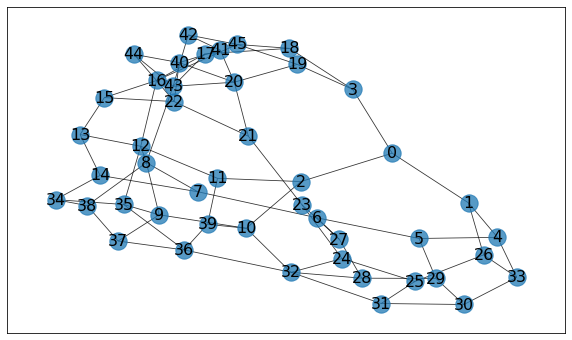

In [9]:
#NB: this is a well known graph known as the "Tutte" graph
edges=[(0, 1), (0, 2), (0, 3), (1, 4), (1, 26), (2, 10), (2, 11), (3, 18), (3, 19), \
       (4, 5), (4, 33), (5, 6), (5, 29), (6, 7), (6, 27), (7, 8), (7, 14), (8, 9), (8, 38), \
       (9, 10), (9, 37), (10, 39), (11, 12), (11, 39), (12, 13), (12, 35), (13, 14), (13, 15),\
       (14, 34), (15, 16), (15, 22), (16, 17), (16, 44), (17, 18), (17, 43), (18, 45), (19, 20), \
       (19, 45), (20, 21), (20, 41), (21, 22), (21, 23), (22, 40), (23, 24), (23, 27), (24, 25), \
       (24, 32), (25, 26), (25, 31), (26, 33), (27, 28), (28, 29), (28, 32), (29, 30), (30, 31), \
       (30, 33), (31, 32), (34, 35), (34, 38), (35, 36), (36, 37), (36, 39), (37, 38), (40, 41), \
       (40, 44), (41, 42), (42, 43), (42, 45), (43, 44)]
#add a few edges for fun and value and to break symmetry
newedges=[(32,36), (32,10), (20,40), (20,43), (8,12), (8,43), (12,16), (35,9), (16,45), (16,22)]
for newedge in newedges:
    edges.append(newedge)

nodes=list(range(46))
neighbors={key: [] for key in range(len(nodes))} 
for edge in edges:
    neighbors[edge[0]].append(edge[1])
    neighbors[edge[1]].append(edge[0])

G=nx.Graph()
G.add_nodes_from(nodes)
for i in range(len(edges)):
    G.add_edge(edges[i][0],edges[i][1])

np.random.seed(4022)
pos = nx.spring_layout(G) #algorithm that tries to "cluster" node plot locations; it saves the xy coords of each vertex
labels=dict(zip(range(46),range(46))); #label 0-45

fig, ax = plt.subplots(figsize=(PLOT_SIZE_X,PLOT_SIZE_Y))

nx.draw_networkx_nodes(G, pos, node_size=300, alpha=.75); #node colors easy to see labels over
nx.draw_networkx_edges(G, pos, width=0.8, alpha=0.8); #draw edges, using xy-node layout provided
nx.draw_networkx_labels(G, pos, labels, font_size=FONT_SIZE); #label vertices by index/number

### Part 1:
Find the Fiedler vector for the graph.  Plot the sorted Fiedler vector.  Use the `edges` array defined above.


In [10]:
class Partition:
    # init function: edges is either a standard square edge-matrix, or a list of edges
    def __init__(self, edges):
        self.edges = edges
        if isinstance(edges, list):
            self.nodes     = list(set([edge[0] for edge in edges] + [edge[1] for edge in edges]))
            self.n         = len(self.nodes)
            self.compute_A = True
        elif isinstance(edges, np.matrix):
            self.nodes     = list(range(edges.shape[0]))
            self.n         = len(self.nodes)
            self.compute_A = False
        else:
            self.nodes     = None
            self.n         = 0
            self.compute_A = False
            print("Wrong Edges format!")
    
    def is_power2(self, n):
        return True if (n & (n-1) == 0) and n != 0 else False
        
    # Retruns the standard square matrix of edges for a graph, as a list of edges as a list of numerical nodes
    # NOTE: maybe one day it would be helpful to rewrite this class to use dicts so nodes can be anything
    def get_A(self, edges, nodes):
        n = len(nodes)
        A = np.zeros((n, n))
        for edge in edges:
            i = nodes.index(edge[0])
            j = nodes.index(edge[1])
            A[i,j] = 1
            A[j,i] = 1
        return A

    # Computes the edge degree for each node returned as a square matrix diagonally
    def get_D(self, A):
        n = A.shape[0]
        D = np.diag([np.sum(A[:,i]) for i in range(n)])
        return D

    def get_L(self, edges):
        # fairly straightforward... Computing the Laplacian (I believe...), stripped straight from lecture/notebook
        A = self.get_A(edges)
        D = self.get_D(A)
        L = D - A
        return L
    
    def get_nodes_from_edges(self, edges):
        s = set()
        for edge in edges:
            s.add(edge[0])
            s.add(edge[1])
        return list(s)
    
    def get_edges(self, g1, g2, edges):
        e1, e2 = [], []
        partitioned_edges = []
        for edge in edges:
            if edge[0] in g1 and edge[1] in g1:
                e1.append(edge)
            elif edge[0] in g2 and edge[1] in g2:
                e2.append(edge)
        return e1, e2
    
    def get_all_edges(self, edges, graphs):
        return [edge for edge in edges for graph in graphs if edge[0] in graph and edge[1] in graph]
    
    def get_fiedler(self, edges, nodes):
        # basically, if edges is given as a matrix, we already have A... So I figured I'd make this a 
        # class variable
        if self.compute_A:
            A = self.get_A(edges, nodes)
        else:
            A = edges
        D = self.get_D(A)
        L = D - A
        # get the eigen-stuff
        eigen_vals, eigen_vecs = np.linalg.eig(L)
        # sort the eigenvalues so we can find the correct eigenvector
        sorted_eigen_vals = np.sort(eigen_vals)
        # I should've used the syntax from the notebook, because this gave me some issues... However, I figured how
        # to make this work!
        index, = np.where(eigen_vals == sorted_eigen_vals[1])
        # NOTE: :,index[1] makes it work... We're looking for the second smallest eigen-pair (Not sure if this is
        # correct mathematical-jargon). Thus, due to Numpy docs, we find the corresponding eigenalue v[i] for 
        # eigenvector w[:,i]:
        # https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html
        fiedler_vec = eigen_vecs[:,index[0]]
        # sort the eigenvector found in previous line
        sorted_fiedler_vec = np.sort(fiedler_vec)
        # sort the indices so we can get the correct order of nodes
        sorted_indices = np.argsort(fiedler_vec)
        true_indices = [nodes[i] for i in sorted_indices]
        return sorted_fiedler_vec, true_indices
    
    def plot_fiedler(self):
        # plots a sorted fiedler vector
        sorted_fiedler_vec, sorted_indices = self.get_fiedler(self.edges, self.nodes)
        fig, ax = plt.subplots(1,1,figsize=(PLOT_SIZE_X,PLOT_SIZE_Y))
        plt.scatter(self.nodes, sorted_fiedler_vec)
        plt.xlabel(r'$\bf{Sorted\ order}$', fontsize=FONT_SIZE)
        plt.ylabel(r'$\bf{Eigenvalue}$', fontsize=FONT_SIZE)
        
    def Bi_partition_helper(self, edges, graph):
        eig_vec, indices = self.get_fiedler(edges, graph)
        g1, g2 = [], []
        for i in range(len(indices)):
            index = indices[i]
            if eig_vec[i] <= 0:
                g1.append(index)
            else:
                g2.append(index)
        return g1, g2
    
    def Bi_partition(self, k):
        graph_list = []
        edge_list  = []
        for i in range(k // 2):
            if i == 0:
                g1, g2 = self.Bi_partition_helper(self.edges, self.nodes)
                graph_list.append(g1)
                graph_list.append(g2)
                e1, e2 = self.get_edges(g1, g2, self.edges)
                edge_list.append(e1)
                edge_list.append(e2)
            else:
                for ii in range(len(graph_list)):
                    g1, g2 = self.Bi_partition_helper(edge_list[ii], graph_list[ii])
                    graph_list.append(g1)
                    graph_list.append(g2)
                    e1, e2 = self.get_edges(g1, g2, edge_list[ii])
                    edge_list.append(e1)
                    edge_list.append(e2)
        return graph_list[-k:], edge_list[-k:]
    
    def K_partition(self, k):
        fiedler_vec, indices = self.get_fiedler(self.edges, self.nodes)
        # simply getting the eigenvalue difference for each value in the eigenvector
        eig_diffs = [np.abs(fiedler_vec[i] - fiedler_vec[i + 1]) for i in range(len(indices) - 1)]
        # initializing the indices of where to cut the graph
        # the crazy line: sorting the indices of the k-1 largest eigenvalue differences
        # while I could've done some iterative method, this could be a relatively incredibly helpful numpy hack
        # thus I googled a good way to do this.
        # https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array
        k_indices = [0] + list(np.sort(np.array(eig_diffs).argsort()[-(k-1):][::-1])) + [len(indices)]
        graphs    = [list(indices[k_indices[i]:k_indices[i + 1]]) for i in range(len(k_indices) - 1)]
        edges     = self.get_all_edges(self.edges, graphs)
        return graphs, edges
    
    def Partition(self, k):
        if self.is_power2(k):
            graphs, edges = self.Bi_partition(k)
        else:
            graphs, edges = self.K_partition(k)
        return graphs, edges
    
    def get_pos(self):
        G=nx.Graph()
        G.add_nodes_from(self.nodes)
        for i in range(len(self.edges)):
            G.add_edge(self.edges[i][0], self.edges[i][1])
        np.random.seed(4022)
        pos = nx.spring_layout(G) #algorithm that tries to "cluster" node plot locations; it saves the xy coords of each vertex
        labels=dict(zip(self.nodes, self.nodes))
        for i in range(len(self.edges)):
            G.remove_edge(self.edges[i][0], self.edges[i][1])
        return pos
    
    def get_colors(self, graphs):
        color_dict = {0: 'yellow', 1: 'red', 2: 'green', 3: 'orange', 4: 'purple', 5: 'blue'}
        return [color_dict[i] for node in self.nodes for i in range(len(graphs)) if node in graphs[i]]
    
    def get_uncut_edges(self, edges):
        return [edge for l in edges for edge in l]
    
    def get_cuts(self, uncut_edges):
        cut_edges = list(set(self.edges).difference(set(uncut_edges)))
        nodes = set()
        for cut_edge in cut_edges:
            nodes.add(cut_edge[0])
            nodes.add(cut_edge[1])
        return list(nodes), cut_edges
    
    def Graph_Partitions(self, k):
        graphs, edges = self.Partition(k)
        pos = self.get_pos()
        colors = self.get_colors(graphs)
        if k % 2 == 0:
            uncut_edges = self.get_uncut_edges(edges)
        else:
            uncut_edges = edges
        cut_nodes, cut_edges = self.get_cuts(uncut_edges)
        G=nx.Graph()
        G.add_nodes_from(self.nodes)
        for i in range(len(uncut_edges)):
            G.add_edge(uncut_edges[i][0], uncut_edges[i][1])
        fig, ax = plt.subplots(figsize=(PLOT_SIZE_X,PLOT_SIZE_Y))
        nx.draw_networkx_nodes(G, pos, node_color=colors, node_size=300, alpha=.75); #node colors easy
        nx.draw_networkx_edges(G, pos, width=1, alpha=0.8); #draw edges, using xy-node layout provided
        nx.draw_networkx_labels(G, pos, labels, font_size=FONT_SIZE); #label vertices by index/number
        G2=nx.Graph()
        G2.add_nodes_from(cut_nodes)
        for i in range(len(cut_edges)):
            G2.add_edge(cut_edges[i][0], cut_edges[i][1])
        nx.draw_networkx_edges(G2, pos, width=5, alpha=0.8); #draw edges, using xy-node layout provided

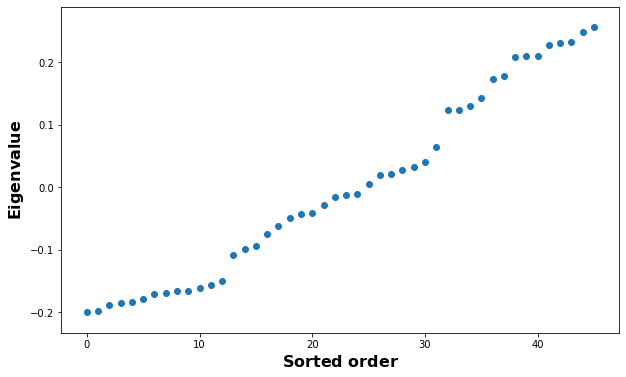

In [11]:
Q4_P1 = Partition(edges)
Q4_P1.plot_fiedler()


### Part 2: Partitions

#### Part 2a:

Partition the graph into 2 graphs using this vector.  Include a picture of the associated *cut* of the graph.


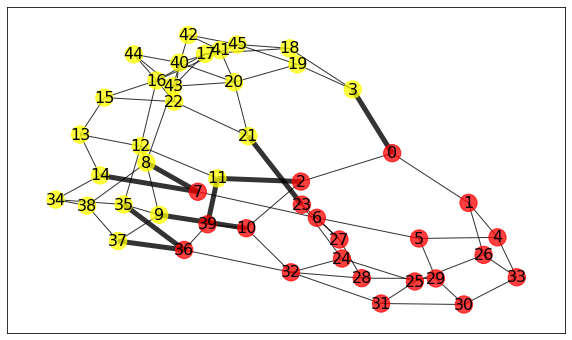

In [12]:
Q4_P2a = Partition(edges)
Q4_P2a.Graph_Partitions(2)


#### Part 2b:

Partition the graph into 3 subgraphs using the Fiedler vector.  One natural way to do so is to partitition at the two largest jumps in the vector and not use $y=0$.  Include both associated *cuts* in another picture of the graph.

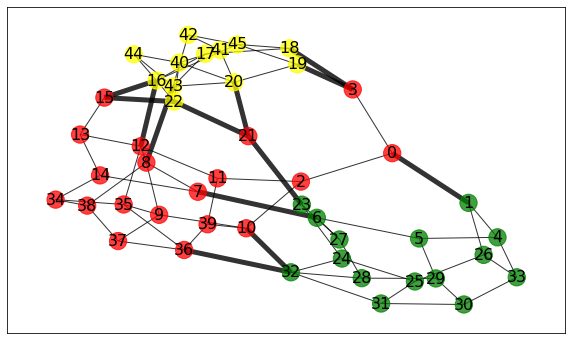

In [13]:
Q4_P2b = Partition(edges)
Q4_P2b.Graph_Partitions(3)



### Part 2c:

Partition the graph into 4 subgraphs using bipartitioning, where you cut once and then cut the resulting subgraphs according to *their* Fiedler vectors.


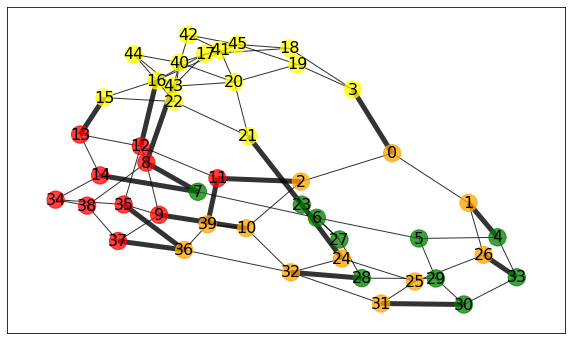

In [14]:
Q4_P2c = Partition(edges)
Q4_P2c.Graph_Partitions(4)
# partitioned graphs
# [3, 19, 18, 41, 45, 20, 42, 21, 40, 17, 44, 22, 43, 16, 15], 
# [13, 12, 8, 11, 14, 35, 9, 38, 34, 37], 
# [7, 6, 27, 5, 23, 29, 28, 4, 30, 33], 
# [24, 25, 26, 31, 1, 32, 0, 36, 10, 2, 39]


### Part 2d:

Of the 3 partitions above, which do you think were most appropriate.  Why?


---

While my graph partition with 4 graphs makes some sense, I'm not 100% sure it's correct. Assuming it is correct though, I think partitioning the graph with either two or three subgraphs makes the most sense in this example. Two or three subgraphs still produce relatively 'clustered' graphs, and four subgraphs has a tough time clustering two of the subgraphs. This made me think there might be some sort of bug in my code when I bipartition twice, however, when looking closely at the cuts in the original graph, my four subgraph's cuts seem reasonable.

---

***
<a/ id='ec'></a>
[Back to top](#top)
# Extra Credit (Running BigCLAM on Big Data: up to +25 pts).  This problem may be turned in either with HW7 or HW8.

Consider the data set `Marvel_Network`.  This set consists of two columns, hero1 and hero2. Every row is filled with co-occurrence of two such marvel characters in a comic.

### Part A) (10 pts) Cleaning and setup
#### (i) Use item baskets to count how many times each character appears.  You may also want to count how many times each *edge* between pairs of characters appears (use your code from A Priori!)

Print the most popular 5 characters' names.


In [15]:
#Names and counts
df = pd.read_csv('Marvel_Network.csv', encoding='unicode_escape')
df.head()

,hero1,hero2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [16]:
class APriori:
    def __init__(self, cleaned_df, basket_column, item_column, k_tuples, support_threshold):
        self.df            = cleaned_df
        self.k             = k_tuples
        self.n             = 0
        # trying to dip my toes in error/exception handling... kinda messy at the moment
        try:
            length         = len(cleaned_df[basket_column].unique())
        except KeyError as a:
            raise NameError("Basket Column is invalid!") from a
        else:
            self.n_baskets = length
            self.s         = int(support_threshold * length)
            self.b_col     = basket_column
        try:
            _ = cleaned_df[item_column]
        except KeyError as b:
            raise NameError("Item Column is invalid!") from b
        else:
            self.i_col     = item_column
    
    def first_pass(self):
        counts = {}
        # counting step that I am resuing from before
        for basket in (self.df.groupby(self.b_col)[self.i_col].apply(list).values):
            for item in basket:
                if item not in counts.keys():
                    counts[item] = 0
                counts[item] += 1
        return prune(counts)
    
    def prune(counts):
        for key in counts.copy():
            if counts[key] < self.s:
                try:
                    del counts[key]
                except KeyError:
                    print("Couldn't remove key: {}".format(key))
        self.n = len(counts)
        return counts
    

    def performAPriori(self, use_hashing=False):
    
        def second_pass(single_counts):
            keys          = single_counts.keys()
            double_counts = {}
            # loop through each basket
            for i, basket in enumerate((self.df.groupby(self.b_col)[self.i_col].apply(list).values)):
                # loop through each item only if its a frequent item
                length = len(basket)
                for i1 in (range(length)):
                    # loop through each item only if its a frequent item and
                    # it's not equal to item in the loop above
                    for i2 in (range(i1+1, length)):
                        # weird stuff to make sure duplicate keys are not added to dict
                        ks = double_counts.keys()
                        t  = (basket[i1], basket[i2])
                        if t not in ks:
                            double_counts[t] = 0    
                        double_counts[t] += 1
            return self.prune(double_counts), confidence(single_counts, double_counts)

        def confidence(old_counts, new_counts):
            confidences = []
            for s_old, c_old in old_counts.items():
                set_old = set([s_old]) if type(s_old) != tuple else set(s_old)
                for s_new, c_new in new_counts.items():
                    set_new = set(s_new)
                    if set(set_old).issubset(set_new):
                        d_set      = set_new.difference(set_old)
                        difference = list(d_set)[0] if len(d_set) == 1 else tuple(d_set)
                        tup        = tuple([(c_new / c_old), "{} -> {}".format(s_old, difference), c_new])
                        confidences.append(tup)
                        c_diff     = old_counts[difference]
                        tup        = tuple([(c_new / c_diff), "{} -> {}".format(difference, s_old), c_new])
                        confidences.append(tup)
            return confidences
        
        if use_hashing:
            pass
            
        frequent_items                 = self.first_pass()
        frequent_pairs, confidences    = second_pass(frequent_items)
        
        sorted_freq_pairs  = [(key, val) for key, val in sorted(frequent_pairs.items(), key=lambda x: x[1], reverse=True)]
        sorted_confidences = [(i[0], i[1]) for i in sorted(confidences, key=lambda x: x[2], reverse=True)]

        return sorted_freq_pairs, sorted_confidences

#### (ii) Remove any characters having degree = 1. What do these nodes represent?

#### (iii) For speed of computation, you should also remove any *edges* with count 1. What do these *edges* represent?

#### (iv) Create an adjacency matrix (or probably a compact/sparse representation of such a matrix!) for the data after accounting for parts (ii), (iii).  How many characters are there?  How many edges?

### Part B)  (10 pts)  Detect communities in the graph generated above using BigCLAM
For this problem, take the number of communities to find as 4 (plus a background community!).  Use your choice of initialization. If you have **prior knowledge** of any comic book characters, consider setting 4 characters from "different" Marvel universes as your seeds.  If not, either use PageRank or properties of your adjacency matrix to decide where to initialize affiliations.

Are the final communities ones you've seen in popular culture?  Verify by checking the community affiliation scores of two characters that you believe should share a dominant community, like Wolverine and Professor X.

### Part C) (5 pts) Detect communities in the graph generated above using *weighted* BigCLAM

It turns out that some edges occurred multiple times in the data set.  We can adjust our model to count the edges proportionately to the number of times they occured: we just have to weight the partial derivatives in our gradient calculation by multiplying each term $v$ in $\nabla F_u$ by the number of times $u$ and $v$ were seen together.

Run the model accordingly, and report the community affiliations of the same pair of characters you looked at in Part B).  They should be even closer now, right?